## DQNでエージェントを構築

In [1]:
import os
import random
import math
from typing import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import copy
from collections import deque
import optuna

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchinfo

import ipytest
ipytest.autoconfig()

## オセロ環境

### オセロゲーム

In [2]:
EMPTY, BLACK, WHITE = 0, 1, -1
DIRECTIONS = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

class OthelloGame:
    def __init__(self):
        self.board = [[EMPTY for _ in range(8)] for _ in range(8)]
        self.board[3][3] = self.board[4][4] = WHITE
        self.board[3][4] = self.board[4][3] = BLACK
        self.player = BLACK

    @staticmethod
    def opponent(player: int) -> int:
        """
        現在のプレイヤーの相手を返す
        Args:
            player(int): 現在のプレイヤー
        Returns:
            int: 相手のプレイヤー
        Examples:
            >>> OthelloGame.opponent(1)
            -1
            >>> OthelloGame.opponent(-1)
            1
        """
        return -player

    def clone(self):
        """盤面をコピーして新しいインスタンスを返す"""
        g = OthelloGame()
        g.board = [row[:] for row in self.board]
        g.player = self.player
        return g

    def inside(self, r, c):
        """
        盤面の範囲内かを返す
        Args:
            r (int): 行
            c (int): 列
        Returns:
            bool: 盤面の範囲内か
        """
        return 0 <= r < 8 and 0 <= c < 8

    def legal_moves(self, player=None) -> List[Tuple[int, int]]:
        """
        合法手を返す
        Args:
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        Returns:
            List[Tuple[int, int]]: 合法手のリスト
        """
        if player is None:
            player = self.player
        moves = []
        for r in range(8):
            for c in range(8):
                if self.board[r][c] != EMPTY:  # 空白でない場合は合法手ではない
                    continue
                if self._would_flip(r, c, player):  # 石をひっくり返せる場合は合法手
                    moves.append((r, c))
        return moves

    def _would_flip(self, r, c, player) -> bool:
        """
        石をひっくり返せるかを返す
        Args:
            r (int): 行
            c (int): 列
            player (int): プレイヤーの色
        Returns:
            bool: 石をひっくり返せるか
        """
        if self.board[r][c] != EMPTY:  # 空白でない場合は石をひっくり返せない
            return False
        for dr, dc in DIRECTIONS:
            rr, cc = r + dr, c + dc
            seen_opp = False  # 相手の石を一度見たか
            while self.inside(rr, cc) and self.board[rr][cc] == self.opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                seen_opp = True
                rr += dr; cc += dc
            if seen_opp and self.inside(rr, cc) and self.board[rr][cc] == player:  # 相手の石を一度見たか & 盤面の範囲内か & 自分の石をみたか
                return True
        return False

    def play(self, r, c, player=None):
        """
        石を置く & 石をひっくり返す
        Args:
            r (int): 行
            c (int): 列
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        """
        if player is None:
            player = self.player
        assert self.board[r][c] == EMPTY  # 空白でない場合は石を置くことができない
        flipped = []
        for dr, dc in DIRECTIONS:
            line = []
            rr, cc = r + dr, c + dc
            while self.inside(rr,cc) and self.board[rr][cc] == self.opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                line.append((rr,cc))  # 石をひっくり返す場所を追加
                rr += dr; cc += dc
            if line and self.inside(rr,cc) and self.board[rr][cc] == player:  # 石をひっくり返す場所が存在 & 盤面の範囲内か & 自分の石をみたか
                flipped.extend(line)  # 石をひっくり返す場所を追加
        if not flipped:  # 石をひっくり返す場所が存在しない場合は不正な手
            raise ValueError("Illegal move")
        self.board[r][c] = player
        for rr,cc in flipped:  # 石をひっくり返す
            self.board[rr][cc] = player
        self.player = self.opponent(player)
        # 現在のプレイヤーが合法手がない場合は相手の番
        if not self.legal_moves(self.player):
            self.player = self.opponent(self.player)

    def is_terminal(self) -> bool:
        """
        終局かを返す
        Returns:
            bool: 終局か
        """
        if self.legal_moves(BLACK): return False
        if self.legal_moves(WHITE): return False
        return True

    def game_score(self) -> int:
        """
        黒が+1, 白が-1としてスコアを計算
        Returns:
            int: スコア
        """
        s = 0
        for r in range(8):
            for c in range(8):
                s += self.board[r][c]
        return s

    def winner(self) -> int:
        s = self.game_score()
        return BLACK if s > 0 else WHITE if s < 0 else 0

### 報酬設計

In [3]:
class OthelloPotential:
    def __init__(
        self,
        player: int,
        w_corner: float = 1.0,
        w_mob: float = 0.7,
        w_frontier: float = -0.4
    ):
        self.player = player
        self.w_corner = w_corner
        self.w_mob = w_mob
        self.w_frontier = w_frontier

    def phi(self, env: OthelloGame) -> float:
        corner_term = self._ratio(*self._count_corner(env))
        mob_term = self._ratio(
            len(env.legal_moves(self.player)),
            len(env.legal_moves(env.opponent(self.player)))
        )
        front_term = self._ratio(*self._count_frontier(env))
        return self.w_corner*corner_term + self.w_mob*mob_term + self.w_frontier*front_term

    def terminal_reward(self, env: OthelloGame) -> float:
        if not env.is_terminal():
            return 0.0
        pc, oc = self._count_stones(env)
        return 1.0 if pc > oc else -1.0 if pc < oc else 0.0

    # --- helpers ---
    def _ratio(self, a: int, b: int) -> float:
        s = a + b
        return (a - b) / max(1, s)

    def _count_stones(self, env: OthelloGame) -> Tuple[int, int]:
        pc = oc = 0
        opp = env.opponent(self.player)
        for r in range(8):
            for c in range(8):
                if env.board[r][c] == self.player: pc += 1
                elif env.board[r][c] == opp: oc += 1
        return pc, oc

    def _count_corner(self, env: OthelloGame) -> Tuple[int, int]:
        corners = [(0,0),(0,7),(7,0),(7,7)]
        pc = oc = 0
        opp = env.opponent(self.player)
        for r,c in corners:
            if env.board[r][c] == self.player: pc += 1
            elif env.board[r][c] == opp: oc += 1
        return pc, oc

    def _count_frontier(self, env: OthelloGame) -> Tuple[int, int]:
        pc = oc = 0
        opp = env.opponent(self.player)
        for r in range(8):
            for c in range(8):
                cell = env.board[r][c]
                if cell == EMPTY:
                    continue
                frontier = any(
                    0 <= r+dr < 8 and 0 <= c+dc < 8 and env.board[r+dr][c+dc] == EMPTY
                    for dr in (-1,0,1) for dc in (-1,0,1) if dr or dc
                )
                if frontier:
                    if cell == self.player: pc += 1
                    elif cell == opp: oc += 1
        return pc, oc

In [4]:
class ShapedReward:
    """
    状態価値を用いた報酬を算出
    r = r_terminal(s') + eta * (gamma * Φ(s') - Φ(s))
    """
    def __init__(self, player: int, eta: float = 0.1, gamma: float = 0.99):
        self.player = player
        self.eta = float(eta)
        self.gamma = float(gamma)
        self.potential = OthelloPotential(player)

    def get_reward(self, prev_env: OthelloGame, next_env: OthelloGame) -> float:
        r_term = self.potential.terminal_reward(next_env)
        phi_prev = self.potential.phi(prev_env)
        phi_next = self.potential.phi(next_env)
        shaped = self.gamma * phi_next - phi_prev
        return r_term + self.eta * shaped

### Gym風API

In [5]:
class OthelloEnv:
    """
    Othello (Reversi) 環境の Gym 風クラス。

    このクラスは強化学習のための環境インターフェースを提供します。
    盤面の初期化、合法手の生成、行動適用、報酬計算、終局判定を行います。

    Attributes:
        game (Othello): ゲーム状態を保持する Othello インスタンス。
        player (int): 現在のプレイヤー (BLACK=1, WHITE=-1)。
    """

    def __init__(self):
        """ コンストラクタ """
        self.game = OthelloGame()
        self.player = self.game.player

    def reset(self):
        """
        環境を初期状態にリセットし、観測を返す
        Returns:
            observation (np.ndarray): 盤面の状態 (8x8の配列)
        """
        self.game = OthelloGame()
        self.player = self.game.player
        return self.get_state()

    def step(self, action, reward_fn=None):
        """
        １ステップ環境を進める
        Args:
            action (int): 0~64の整数（64はパス）
            reward_fn (Reward, Optional): 報酬関数のインスタンス
                指定された場合、行動適用後に報酬を計算
        Returns:
            tuple:
                - observation (np.ndarray): 次の盤面の状態 (8x8, float32)
                - reward (float): 報酬
                - done (bool): ゲーム終了フラグ
                - info (dict): 追加情報
        """
        done = False
        reward = 0.0

        prev_game = self.game.clone()

        try:
            if action == 64:  # パスの場合
                # パスして相手番
                self.game.player = self.game.opponent(self.game.player)
            else:
                r, c = divmod(action, 8)
                self.game.play(r, c, self.game.player)
        except ValueError:
            # 不正手なら、即終了 & 負の報酬
            done = True
            reward = -10.0
            return self.get_state(), reward, done, {}

        # 報酬を計算
        if reward_fn is not None:
            reward = reward_fn(prev_game, self.game)

        done = self.game.is_terminal()
        self.player = self.game.player

        return self.get_state(), reward, done, {}

    def get_state(self):
        """
        現在の盤面をnumpy配列で取得
        Returns:
            observation (np.ndarray): 盤面の状態 (8x8, float32)
        """
        return np.array(self.game.board, dtype=np.float32)

    def legal_actions(self):
        """
        現在のプレイヤーの合法手を整数インデックスのリストとして返す
        Returns:
            actions (list): 合法手の整数インデックスのリスト
        """
        moves = self.game.legal_moves(self.player)
        if not moves:
            return [64]
        return [r * 8 + c for r, c in moves]

    def render(self):
        """
        盤面をコンソールに出力する
        """
        board_np = np.array(self.game.board)
        print(board_np)

## DQNのネットワーク定義

In [6]:
class DSConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.dw = nn.Conv2d(
            in_channels=in_channels, out_channels=in_channels,
            kernel_size=3, padding=1, groups=in_channels, bias=False,
        )
        self.pw = nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels,
            kernel_size=1, bias=False,
        )
        self.gn = nn.GroupNorm(num_groups=1, num_channels=out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.gn(x)
        x = self.act(x)
        return x


class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(
                in_channels=2, out_channels=8,
                kernel_size=3, padding=1, bias=False,
            ),
            nn.SiLU(),
        )
        self.block1 = DSConv(in_channels=8, out_channels=8)
        self.block2 = DSConv(in_channels=8, out_channels=8)

        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8, out_features=65),
            nn.SiLU(),
        )
        self.head = nn.Linear(in_features=65, out_features=65)  # 65番目は、パスの行動

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.gap(x)
        x = self.fc(x)
        x = self.head(x)
        return x

In [7]:
# アーキテクチャのテスト
dqn = DQN()
dummy_board = torch.zeros((1, 1, 8, 8))
dummy_player = torch.ones((1, 1, 8, 8))  # 手番 +1
dummy_input = torch.cat([dummy_board, dummy_player], dim=1)  # (1,2,8,8)
print(dqn(dummy_input).shape)
torchinfo.summary(dqn, (1, 2, 8, 8))

torch.Size([1, 65])


Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 65]                   --
├─Sequential: 1-1                        [1, 8, 8, 8]              --
│    └─Conv2d: 2-1                       [1, 8, 8, 8]              144
│    └─SiLU: 2-2                         [1, 8, 8, 8]              --
├─DSConv: 1-2                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-3                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-4                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-5                    [1, 8, 8, 8]              16
│    └─SiLU: 2-6                         [1, 8, 8, 8]              --
├─DSConv: 1-3                            [1, 8, 8, 8]              --
│    └─Conv2d: 2-7                       [1, 8, 8, 8]              72
│    └─Conv2d: 2-8                       [1, 8, 8, 8]              64
│    └─GroupNorm: 2-9                    [1, 8, 8, 8]              16
│    └─SiLU: 2

## DQNの学習

In [8]:
class ReplayBuffer:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self.memory = deque(maxlen=memory_size)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
class TrainDoubleDQN:
    """Double DQN の学習クラス

    Double DQN による Q 学習を実装します。経験再生、ターゲットネット更新、
    ε-greedy 探索を備え、直近 N エピソードの平均報酬が改善したときに
    ベストモデルを保持します。

    Args:
        dqn (nn.Module): Qネットワーク（入力: (B,2,8,8), 出力: (B,65)）
        gamma (float): 割引率。Defaults to ``0.99``.
        lr (float): 学習率。Defaults to ``1e-3``.
        batch_size (int): バッチサイズ。Defaults to ``64``.
        init_memory_size (int): リプレイ初期化のために集める遷移数。Defaults to ``5000``.
        memory_size (int): リプレイバッファ容量。Defaults to ``50000``.
        target_update_freq (int): ハードターゲット更新の頻度（更新回数）。Defaults to ``1000``.
        tau (float): ソフト更新係数（>0 で Polyak）。``0.0`` ならハード更新。Defaults to ``0.0``.
        num_episodes (int): 学習エピソード数。Defaults to ``1000``.
        max_steps_per_episode (int): 1エピソードの最大ステップ。Defaults to ``120``.
        train_freq (int): 何環境ステップごとに学習を走らせるか。Defaults to ``1``.
        gradient_steps (int): 1回の学習トリガでの更新回数。Defaults to ``1``.
        learning_starts (int): これ未満は学習を行わない。Defaults to ``1000``.
        epsilon_start (float): ε-greedy 初期値。Defaults to ``1.0``.
        epsilon_end (float): ε-greedy 最終値。Defaults to ``0.05``.
        epsilon_decay_steps (int): ε を線形減衰させるステップ数。Defaults to ``30000``.
        seed (int): 乱数シード。Defaults to ``42``.
        device (torch.device): 使用デバイス。None なら自動選択。
        ReplayBufferCls (type): リプレイバッファクラス（append/sample 実装必須）。
        shaping_eta (float): ポテンシャルシェーピング係数 η。Defaults to ``0.1``.
        rolling_window (int): ベスト判定のローリング平均窓幅。Defaults to ``100``.
        save_best_path (str): ベスト更新ごとに保存するパス。None なら保存なし。

    Attributes:
        rewards (List[float]): 各エピソードの合計報酬ログ。
        losses (List[float]): 各更新の損失ログ。
        best_state_dict (Dict[str, torch.Tensor]): ベストモデルの重み。
        best_score (float): ローリング平均のベストスコア。
    """

    # =============================
    # 初期化
    # =============================
    def __init__(
        self,
        dqn,
        gamma: float = 0.99,
        lr: float = 1e-3,
        batch_size: int = 64,
        init_memory_size: int = 5000,
        memory_size: int = 50000,
        target_update_freq: int = 1000,
        tau: float = 0.0,
        num_episodes: int = 1000,
        max_steps_per_episode: int = 120,
        train_freq: int = 1,
        gradient_steps: int = 1,
        learning_starts: int = 1000,
        epsilon_start: float = 1.0,
        epsilon_end: float = 0.05,
        epsilon_decay_steps: int = 30000,
        seed: int = 42,
        device: Optional[torch.device] = None,
        ReplayBufferCls=None,
        shaping_eta: float = 0.1,
        rolling_window: int = 100,
        save_best_path: Optional[str] = None,
    ):
        assert ReplayBufferCls is not None, "ReplayBufferCls を渡してください"
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 乱数シード固定（再現性）
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

        # オンライン/ターゲットネットの構築
        self.dqn = dqn.to(self.device)
        self.target_dqn = copy.deepcopy(dqn).to(self.device)
        self.target_dqn.eval()

        # 最適化器・損失関数
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)
        self.loss_fn = nn.SmoothL1Loss()  # Huber

        # ハイパーパラメータ類
        self.gamma = gamma
        self.batch_size = batch_size
        self.init_memory_size = init_memory_size
        self.max_steps_per_episode = max_steps_per_episode
        self.num_episodes = num_episodes
        self.train_freq = max(1, int(train_freq))
        self.gradient_steps = max(1, int(gradient_steps))
        self.learning_starts = int(learning_starts)

        # ターゲット更新関連
        self.tau = float(tau)
        self.target_update_freq = int(target_update_freq)
        self._num_updates = 0  # optimizer.step() 回数
        self._num_env_steps = 0  # 環境ステップ数（ε 減衰にも使用）

        # ε-greedy パラメータ
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = max(1, int(epsilon_decay_steps))

        # 経験再生
        self.replay_buffer = ReplayBufferCls(memory_size)

        # shaping 係数
        self.shaping_eta = float(shaping_eta)

        # ログ/ベスト追跡
        self.rewards: List[float] = []
        self.losses: List[float] = []
        self.rolling_window = int(rolling_window)
        self.best_score = -float("inf")
        self.best_state_dict = copy.deepcopy(self.dqn.state_dict())
        self.save_best_path = save_best_path

        # ランダムプレイでリプレイを初期化
        self._init_replay_buffer()

    # =============================
    # 公開 API
    # =============================
    def train(self, return_best_model: bool = False):
        """指定エピソード数だけ学習を実行し、必要ならベストモデルも返す。

        エピソードを順に実行し、経験を蓄積・学習します。ローリング平均で
        ベストが更新されたら状態辞書を保持し、オプションでファイルにも保存します。

        Args:
            return_best_model (bool, optional): True の場合、metrics とともに
                ベストモデル（deepcopy 済み）を返します。

        Returns:
            Dict[str, List[float]] | Tuple[Dict[str, List[float]], nn.Module]:
                メトリクス辞書（rewards, losses）。return_best_model=True なら
                これに加えてベストモデルを返します。
        """
        pbar = tqdm(total=self.num_episodes, desc="Train Double DQN")
        for ep in range(self.num_episodes):
            # 1 エピソード実行
            ep_reward = self._run_episode(ep)
            self.rewards.append(ep_reward)

            # 直近ローリング平均（窓幅に達するまでは全体平均）
            if len(self.rewards) >= self.rolling_window:
                rolling_avg = float(np.mean(self.rewards[-self.rolling_window:]))
            else:
                rolling_avg = float(np.mean(self.rewards))

            # ベスト更新判定
            if rolling_avg > self.best_score:
                self.best_score = rolling_avg
                self.best_state_dict = copy.deepcopy(self.dqn.state_dict())
                if self.save_best_path is not None:
                    torch.save(self.best_state_dict, self.save_best_path)

            # 進捗バーの表示
            last_loss = self.losses[-1] if self.losses else float("nan")
            pbar.set_postfix_str(
                f"Episode Reward: {ep_reward:.2f}  Roll@{self.rolling_window}: {rolling_avg:.2f}  "
                f"Best: {self.best_score:.2f}  Loss: {last_loss:.3f}  ε: {self._epsilon_by_step(self._num_env_steps):.3f}"
            )
            pbar.update(1)
        pbar.close()

        metrics = {"rewards": self.rewards, "losses": self.losses}
        if return_best_model:
            best_model = self._clone_model_with_state(self.best_state_dict)
            return metrics, best_model
        return metrics

    def get_best_model(self) -> nn.Module:
        """保持しているベストの重みで初期化したモデルを返す。

        Returns:
            nn.Module: deepcopy 済みのモデルに best_state_dict を load して eval() 済み。
        """
        return self._clone_model_with_state(self.best_state_dict)

    # =============================
    # 内部ヘルパ
    # =============================
    def _clone_model_with_state(self, state_dict) -> nn.Module:
        """オンラインネットのクローンを作成し、指定の重みを読み込む。

        Args:
            state_dict (Dict[str, torch.Tensor]): ロードする重み。

        Returns:
            nn.Module: device 上に配置され eval() 済みのコピー。
        """
        model = copy.deepcopy(self.dqn).to(self.device)
        model.load_state_dict(state_dict)
        model.eval()
        return model

    def _run_episode(self, episode_idx: int) -> float:
        """1 エピソード分の相互作用を実行して合計報酬を返す。

        環境に対して ε-greedy で行動し、経験をリプレイバッファへ保存。
        train_freq ごとに学習を走らせ、必要に応じてターゲット更新を行います。

        Args:
            episode_idx (int): エピソード番号（ログ/拡張用）。

        Returns:
            float: 当該エピソードの合計報酬。
        """
        env = OthelloEnv()
        total_reward = 0.0
        steps = 0
        done = False

        while not done and steps < self.max_steps_per_episode:
            # ε-greedy で行動選択
            epsilon = self._epsilon_by_step(self._num_env_steps)
            player = env.player  # 現在手番（+1/-1）
            state = env.get_state()  # (8,8) float32
            action = self._select_action_by_epsilon_greedy(env, epsilon)

            # シェーピング報酬：prev/next から r を算出
            shaped = ShapedReward(player, eta=self.shaping_eta, gamma=self.gamma)
            next_state, reward, done, _ = env.step(action, reward_fn=shaped.get_reward)
            next_player = env.player

            # 次状態の合法手とともに遷移を保存
            next_legal_actions = self._legal_actions_from_board(next_state, next_player)
            self._store_transition(
                board=state,
                action=action,
                reward=reward,
                next_board=next_state,
                done=done,
                player=player,
                next_player=next_player,
                next_legal_actions=next_legal_actions,
            )

            # バッファが暖まっていれば学習を実行
            if (self._num_env_steps % self.train_freq == 0) and (len(self.replay_buffer) >= max(self.batch_size, self.learning_starts)):
                for _ in range(self.gradient_steps):
                    loss = self._update_dqn_double()
                    if not math.isnan(loss):
                        self.losses.append(loss)

            # 必要ならターゲット更新
            self._maybe_update_target()

            total_reward += float(reward)
            steps += 1
            self._num_env_steps += 1

        return float(total_reward)

    def _update_dqn_double(self) -> float:
        """Double DQN の 1 回分の更新を実行して損失を返す。

        next 状態でオンラインネットにより argmax を選び、ターゲットネットで
        その値を評価（Double DQN）。かつ、合法手のみを有効化するマスクを適用します。

        Returns:
            float: Huber 損失のスカラー値。
        """
        batch = self.replay_buffer.sample(self.batch_size)

        boards_np = np.stack([b['board'] for b in batch])              # (B,8,8)
        next_boards_np = np.stack([b['next_board'] for b in batch])    # (B,8,8)
        players_np = np.array([b['player'] for b in batch], dtype=np.float32)
        next_players_np = np.array([b['next_player'] for b in batch], dtype=np.float32)

        board = self._batch_to_input(boards_np, players_np)            # (B,2,8,8)
        next_board = self._batch_to_input(next_boards_np, next_players_np)

        # (B,2,8,8) テンソルを構築（チャネル0=盤面, チャネル1=手番）
        board = torch.stack([self._to_input(b['board'], b['player']) for b in batch]).to(self.device)
        next_board = torch.stack([self._to_input(b['next_board'], b['next_player']) for b in batch]).to(self.device)

        # スカラー群
        action = torch.tensor([b['action'] for b in batch], dtype=torch.int64, device=self.device)
        reward = torch.tensor([b['reward'] for b in batch], dtype=torch.float32, device=self.device)
        done = torch.tensor([b['done'] for b in batch], dtype=torch.float32, device=self.device)
        next_legal_actions_list = [b['next_legal_actions'] for b in batch]

        # Q(s,a) を抽出
        q_all = self.dqn(board)                                 # (B,65)
        q_sa = q_all.gather(1, action.unsqueeze(1)).squeeze(1)  # (B,)

        with torch.no_grad():
            # 次状態で非合法手をマスク（-1e9 加算）
            next_masks = self._build_masks_from_indices(next_legal_actions_list, fill_value=-1e9)
            q_next_online = self.dqn(next_board) + next_masks
            next_actions_online = q_next_online.argmax(dim=1)  # (B,)

            # ターゲットネットで評価
            q_next_target = self.target_dqn(next_board)
            next_q = q_next_target.gather(1, next_actions_online.unsqueeze(1)).squeeze(1)  # (B,)

            # ベルマンターゲット
            target = reward + self.gamma * next_q * (1.0 - done)

        loss = self.loss_fn(q_sa, target)
        if torch.isnan(loss):  # まれな数値異常を検知
            return float("nan")

        # 逆伝播と最適化
        self.optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.dqn.parameters(), max_norm=1.0)
        self.optimizer.step()

        self._num_updates += 1
        return float(loss.item())

    def _select_action_by_epsilon_greedy(self, env, epsilon: float) -> int:
        """ε-greedy に基づき合法手の中から行動をサンプルする。

        Args:
            env (OthelloEnv): 環境インスタンス。
            epsilon (float): 探索率 ε（0〜1）。

        Returns:
            int: 選択した行動インデックス（0..64）。
        """
        legal_actions = env.legal_actions()
        if random.random() < epsilon:
            return random.choice(legal_actions)
        return self._select_action_by_greedy(env)

    def _select_action_by_greedy(self, env) -> int:
        """合法手のみを対象に Q を比較し、貪欲（argmax）に行動を選ぶ。

        Args:
            env (OthelloEnv): 環境インスタンス。

        Returns:
            int: 貪欲に選んだ行動インデックス（0..64）。
        """
        legal_actions = env.legal_actions()
        board_tensor = self._to_input(env.get_state(), env.player).unsqueeze(0).to(self.device)  # (1,2,8,8)
        with torch.no_grad():
            q_all = self.dqn(board_tensor).squeeze(0)  # (65,)
            # 非合法手を巨大負値で潰す
            mask = torch.full((65,), -1e9, device=self.device)
            for a in legal_actions:
                mask[a] = 0.0
            q_masked = q_all + mask
            action = int(q_masked.argmax().item())
        return action

    def _init_replay_buffer(self):
        """ランダムポリシーで遷移を収集し、リプレイバッファを初期化する。"""
        target = min(self.init_memory_size, self.replay_buffer.memory_size)
        added = 0
        pbar = tqdm(total=target, desc='Init replay buffer')
        while added < target:
            env = OthelloEnv()
            done = False
            while not done and added < target:
                player = env.player
                state = env.get_state()
                legal_actions = env.legal_actions()
                action = random.choice(legal_actions)
                shaped = ShapedReward(player, eta=self.shaping_eta, gamma=self.gamma)
                next_state, reward, done, _ = env.step(action, reward_fn=shaped.get_reward)
                next_player = env.player
                next_legal_actions = self._legal_actions_from_board(next_state, next_player)

                self._store_transition(
                    board=state,
                    action=action,
                    reward=reward,
                    next_board=next_state,
                    done=done,
                    player=player,
                    next_player=next_player,
                    next_legal_actions=next_legal_actions,
                )
                added += 1
                pbar.update(1)
        pbar.close()

    def _maybe_update_target(self):
        """ターゲットネットを Polyak またはハードコピーで更新する。

        * tau > 0 の場合: ``target = (1-tau)*target + tau*online``（ソフト更新）
        * それ以外: optimizer の更新回数で target_update_freq ごとにハード更新
        """
        if self.tau and self.tau > 0.0:
            with torch.no_grad():
                for tp, p in zip(self.target_dqn.parameters(), self.dqn.parameters()):
                    tp.data.mul_(1.0 - self.tau).add_(self.tau * p.data)
        else:
            if (self._num_updates % max(1, self.target_update_freq)) == 0 and self._num_updates > 0:
                self.target_dqn.load_state_dict(self.dqn.state_dict())

    def _epsilon_by_step(self, step: int) -> float:
        """環境ステップ数に応じて ε を線形減衰させる。

        Args:
            step (int): 現在の環境ステップ数。

        Returns:
            float: [epsilon_end, epsilon_start] の範囲での ε 値。
        """
        if step >= self.epsilon_decay_steps:
            return self.epsilon_end
        span = self.epsilon_start - self.epsilon_end
        return self.epsilon_start - span * (step / self.epsilon_decay_steps)

    def _build_masks_from_indices(self, batch_next_legal_actions, fill_value: float = -1e9):
        """次状態ごとの合法手リストから加算マスクを作る。

        Args:
            batch_next_legal_actions (List[List[int]]): 各バッチにおける合法手のリスト。
            fill_value (float): 非合法手に与える値（例: -1e9）。Defaults to ``-1e9``.

        Returns:
            torch.Tensor: 形状 (B,65) のマスクテンソル（合法手は 0、非合法手は fill_value）。
        """
        B = len(batch_next_legal_actions)
        masks = torch.full((B, 65), float(fill_value), device=self.device)
        for i, acts in enumerate(batch_next_legal_actions):
            for a in acts:
                masks[i, a] = 0.0
        return masks

    def _to_input(self, board_like, player_scalar: int) -> torch.Tensor:
        """盤面と手番スカラーから 2 チャンネルテンソルを生成する。

        チャネル0: 盤面（-1,0,+1）。チャネル1: 手番プレーン（+1/-1 で全面を塗る）。

        Args:
            board_like (array-like): 形状 (8,8) または (1,8,8) の配列。
            player_scalar (int): +1（黒手番）または -1（白手番）。

        Returns:
            torch.Tensor: 形状 (2,8,8) の float32 テンソル。
        """
        t = torch.as_tensor(board_like, dtype=torch.float32)
        if t.dim() == 2 and t.shape == (8, 8):
            t = t.unsqueeze(0)  # (1,8,8)
        elif t.dim() == 3 and t.shape == (1, 8, 8):
            pass
        else:
            t = t.reshape(1, 8, 8)
        player_plane = torch.full_like(t, float(player_scalar))  # (1,8,8)
        return torch.cat([t, player_plane], dim=0)  # (2,8,8)

    def _batch_to_input(self, boards_np: np.ndarray, players_np: np.ndarray) -> torch.Tensor:
        """
        boards_np: (B, 8, 8), players_np: (B,)
        """
        t = torch.as_tensor(boards_np, dtype=torch.float32, device=self.device).unsqueeze(1)  # (B,1,8,8)
        p = torch.as_tensor(players_np, dtype=torch.float32, device=self.device).view(-1,1,1,1).expand(-1,1,8,8)
        return torch.cat([t, p], dim=1)  # (B,2,8,8)

    def _legal_actions_from_board(self, board_np: np.ndarray, player: int) -> List[int]:
        """次状態の盤面と手番から合法手（インデックス配列）を再計算する。

        Args:
            board_np (np.ndarray): 形状 (8,8) の盤面（np.float32 互換）。
            player (int): +1（黒）または -1（白）。

        Returns:
            List[int]: 合法手のインデックス。合法手が無ければ [64]（パス）。
        """
        # ここでは副作用を避けるため、OthelloGame を新規に作り直す
        g = OthelloEnv().game.__class__()  # 既存環境からゲームクラスを取得して生成
        g.board = board_np.astype(np.int8).tolist()
        g.player = player
        moves = g.legal_moves(player)
        if not moves:
            return [64]
        return [r * 8 + c for r, c in moves]

    def _store_transition(
        self,
        board,
        action: int,
        reward: float,
        next_board,
        done: bool,
        player: int,
        next_player: int,
        next_legal_actions: List[int],
    ):
        """1 ステップ分の遷移をリプレイバッファに保存する。

        Args:
            board (np.ndarray): 現在の盤面 (8,8)。
            action (int): 実行した行動インデックス。
            reward (float): 即時報酬。
            next_board (np.ndarray): 次の盤面 (8,8)。
            done (bool): 終局フラグ。
            player (int): 現在盤面での手番（+1/-1）。
            next_player (int): 次盤面での手番（+1/-1）。
            next_legal_actions (List[int]): 次状態での合法手インデックス一覧。
        """
        transition = {
            "board": np.array(board, dtype=np.float32),
            "action": int(action),
            "reward": float(reward),
            "next_board": np.array(next_board, dtype=np.float32),
            "done": bool(done),
            "player": int(player),
            "next_player": int(next_player),
            "next_legal_actions": next_legal_actions,
        }
        self.replay_buffer.append(transition)


device: mps


Init replay buffer:   0%|          | 0/5000 [00:00<?, ?it/s]

Train Double DQN:   0%|          | 0/200 [00:00<?, ?it/s]

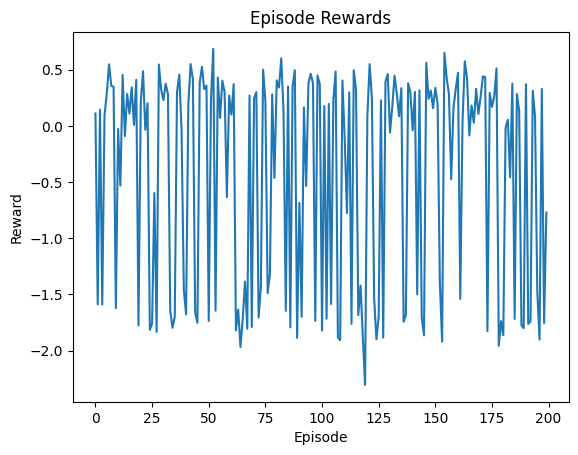

Best model loaded into trainer.dqn


In [10]:
# ==== 学習の実行（最小例） ====

# デバイス自動選択
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)
print("device:", device)

# DQN を作成（あなたの2ch対応版）
dqn = DQN().to(device)

# リプレイバッファ
replay_cls = ReplayBuffer  # 既に定義済みのクラスを使う

# ハイパラ（まずは軽めに）
trainer = TrainDoubleDQN(
    dqn=dqn,
    device=device,
    ReplayBufferCls=replay_cls,
    num_episodes=200,       # 動作確認用。学習させるなら徐々に増やす（1,000〜10,000など）
    batch_size=128,
    gamma=0.99,
    lr=5e-4,
    target_update_freq=2000,
    epsilon_start=1.0,
    epsilon_end=0.05,
    epsilon_decay_steps=20000,
    max_steps_per_episode=120,
    shaping_eta=0.1,
    rolling_window=100,
    save_best_path="best_dqn.pth",  # ベスト更新のたび保存（不要なら None）
)

# 学習開始：ベストモデルも受け取る
metrics, best_model = trainer.train(return_best_model=True)

# 学習曲線を確認
plt.figure()
plt.plot(metrics["rewards"])
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# ベスト重みでオンラインネットを上書き（以降の推論に反映したい場合）
trainer.dqn.load_state_dict(best_model.state_dict())
trainer.dqn.eval()
print("Best model loaded into trainer.dqn")